# k-means from scratch

In this walkthrough, we will learn how to implement the k-means clustering algorithm from scratch using Python.

#### Here are the dependencies & requirements for running the code in this notebook:
 - Python 3.6
 - `pandas`
 - `numpy`
 - `sci-kit learn`
 - `matplotlib`
 - `seaborn`
 
#### Here is a high-level overview of what we'll cover tonight:
1. Introduction & Background
2. How do we train a k-means model?
3. How do we use and evaluate our model? Show me pretty pictures.
4. How does our "from-scratch" implementation compare to a standard ML library?

## 1. Introduction & Background
The k-means clustering algorithm is an unsupervised machine learning method that is useful for identifying similar groups in your dataset.

The $ k $ refers to the number of partitions (or clusters) we aim to separate our data into.

The $ means $ refers to the fact that each data point will belong a specific cluster with the nearest mean. Said differently, each of the clusters will have a mean that is calculated using the points belonging to that cluster. Individual points will be assigned to a specific cluster based upon the distance of the individual point to the cluster mean. Whichever distance is the smallest, the individual data point will be assigned to that cluster.

## 2. How do we train a k-means model?
The most common implementation uses an **iterative refinement technique** which means that we will *assign* each of our data points to a cluster with the nearest mean, and then *update* the mean of each cluster.

The mean of each cluster is what we call a **representative point** (or centroid). These centroids will change in each step of our iterative refinement technique, until the centroids no longer change (i.e., converge). A common approach for initializing the centroids is to just pick $ k $ points randomly.

OK, that sounds great. But I [still don't get it.](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

*Why haven't you shown me any code yet?*

### Let's get some data
We'll be using the [infamous iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) which is commonly used for testing out machine learning tasks. 

*Sidebar/Spoiler: The iris dataset is commonly used for classification - one of my goals of this walkthrough is to differentiate clustering from classification.*

It contains 150 records and four features, with 50 records belonging to each of the three classes.

In [120]:
import pandas as pd
import numpy as np
import os
import time
import math
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
import seaborn as sns
import matplotlib.pyplot as plt
from helper import silhouette_coefficient

warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True)
%matplotlib inline

def get_iris_data(file_name):
    """Simple function to pre-process the iris dataset."""

    # Specify column names and read in data
    i_names = ['s_len', 's_wid', 'p_len', 'p_wid', 'species']
    iris = pd.read_table(os.path.join(os.getcwd(), file_name), header=None, sep=',', names=i_names)

    return iris

In [101]:
df = get_iris_data('iris.data')
df.head()

,s_len,s_wid,p_len,p_wid,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [102]:
print("The data set contains {} records and {} features.".format(df.shape[0], df.shape[1]))

The data set contains 150 records and 5 features.


In [103]:
df['species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64

### Let's check out the distribution of two features among the three classes.

We can test out different feature combinations to see how the values are distributed based upon the classes.

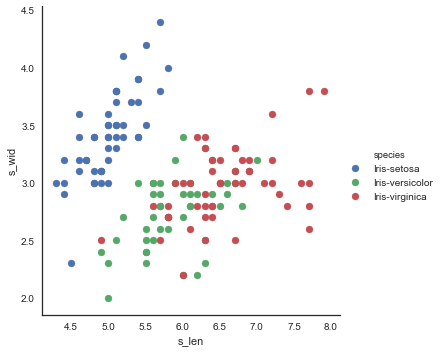

In [54]:
sns.FacetGrid(df, hue="species", size=5) \
   .map(plt.scatter, "s_len", "s_wid") \
   .add_legend()

We can also just look at one of the features to get a better sense of a feature's distribution.

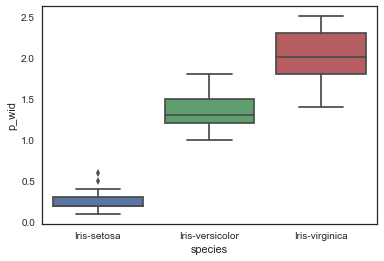

In [82]:
sns.boxplot(x="species", y="p_wid", data=df)

### Let's get down to business

Now we're *finally* going to implement our iterative refinement technique. 

At the highest level, here's the pseudocode to do so:

    Initialize centroids
    
    Enter loop
        
        Stash copy of old centroids
        Calculate distance from each data point to centroid
        Assign each data point to cluster with closest mean
        Calculate the new means of each cluster
        Update the centroids
        
    Continue until centroids converge
    
And the corresponding "code-code":

In [122]:
class KMeans:
    """The k-means algorithm."""

    def __init__(self, n_clusters):
        self.data = pd.DataFrame()
        self.n_clusters = n_clusters
        self.centroids = pd.DataFrame()
        self.clusters = np.ndarray(1)
        self.old_centroids = pd.DataFrame()
        self.verbose = False
        self.predictions = list()

    def train(self, df, verbose):
        self.verbose = verbose
        self.data = df.copy(deep=True)
        self.clusters = np.zeros(len(self.data))

        if 'species' in self.data.columns:
            self.data.drop('species', axis=1, inplace=True)

        # Randomly initialize centroids
        unique_rows = self.data.drop_duplicates()
        unique_rows.reset_index(drop=True, inplace=True)
        self.centroids = unique_rows.sample(n=self.n_clusters)
        self.centroids.reset_index(drop=True, inplace=True)

        if self.verbose:
            print("\nRandomly initiated centroids:")
            print(self.centroids)

        # Initialize old centroids as a matrix of all 0's
        self.old_centroids = pd.DataFrame(np.zeros(shape=(self.n_clusters, self.data.shape[1])),
                                          columns=self.data.columns)

        # Compare every data point in our dataset to each of the k-means and assign each point to closest cluster
        while not self.old_centroids.equals(self.centroids):
            
            if self.verbose:
                time.sleep(3)

            # Stash old centroids
            self.old_centroids = self.centroids.copy(deep=True)

            # Iterate through each data point in the matrix
            for row_i in range(0, len(self.data)):
                distances = list()
                point = self.data.iloc[row_i]

                # Calculate the distance between the current point and each of the centroids
                for row_c in range(0, len(self.centroids)):
                    centroid = self.centroids.iloc[row_c]
                    distances.append(np.linalg.norm(point - centroid))

                # Assign this data point to a cluster
                self.clusters[row_i] = np.argmin(distances)

            # For each cluster extract the values which now belong to each cluster and calculate new k-means
            for cls in range(0, self.n_clusters):

                cls_idx = np.where(self.clusters == cls)[0]

                if len(cls_idx) == 0:
                    self.centroids.loc[cls] = self.old_centroids.loc[cls]
                else:
                    # Set the new k-mean to the mean value of the data points within this cluster
                    self.centroids.loc[cls] = self.data.iloc[cls_idx].mean()
                    
                if self.verbose:
                    print("\nRow indices belonging to cluster {}: [n={}]".format(cls, len(cls_idx)))
                    print(cls_idx)

            if self.verbose:
                print("\nOld centroids:")
                print(self.old_centroids)
                print("New centroids:")
                print(self.centroids)

In [129]:
# Run through a simple application
number_of_clusters = 2
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.train(df=df, verbose=False)

In [106]:
# Extract the results
df['cluster'] = kmeans.clusters
centroids = kmeans.centroids
centroids['cluster'] = 'centroid'
all_df = pd.concat([df, centroids])

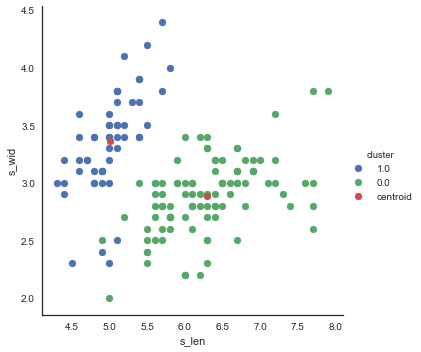

In [107]:
# Plot the cluster centroids
sns.FacetGrid(all_df, hue="cluster", size=5, hue_kws={"marker":["o", "o", "o", "x"]}).map(plt.scatter, "s_len", "s_wid").add_legend()

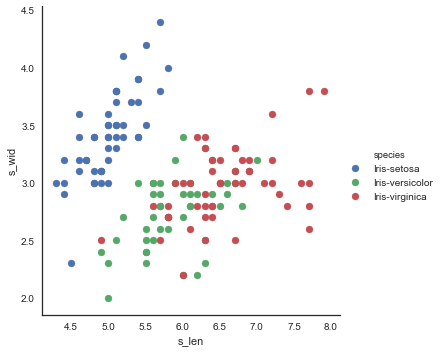

In [108]:
# Plot the clusters
sns.FacetGrid(all_df, hue="species", size=5).map(plt.scatter, "s_len", "s_wid").add_legend()

## 3. How do we evaluate our model?
So we've implemented our algorithm - now what do we do with it?

How do we know that setting $ k = 2 $ is better than $ k = 5 $? How can we back that up with some proof?

In [142]:
sil_coefs = list()

for cluster_number in [2, 3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=cluster_number)
    kmeans.train(df=df, verbose=False)
    perf = silhouette_coefficient(df=df, clusters=kmeans.clusters, n_clusters=cluster_number)
    print("\nAvg. silhouette coefficient for k={}: {}".format(cluster_number, perf))
    sil_coefs.append(perf)


Avg. silhouette coefficient for k=2: 0.6936772807489379

Avg. silhouette coefficient for k=3: 0.5494015416191254

Avg. silhouette coefficient for k=4: 0.4930976542740997

Avg. silhouette coefficient for k=5: 0.3492692536501152

Avg. silhouette coefficient for k=6: 0.3215734972322463
